In [1]:
import re
import nltk
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_packed_sequence
from sklearn.metrics import precision_recall_curve
from matplotlib.font_manager import FontProperties
from torch.nn.utils.rnn import pack_padded_sequence
from keras.preprocessing.sequence import pad_sequences
stopwords = stopwords.words('english')

In [2]:
batch_size = 128
embedding_dim = 64
filter_size = [3,4,5]
filter_num_textcnn = 100
filter_num_cnnlstm = 32
n_hidden = 128

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
train_df = pd.read_csv("./train.txt", sep=";", header= None, names=["text", "label"])
val_df = pd.read_csv("./val.txt", sep=";", header= None, names=["text", "label"])
test_df = pd.read_csv("./test.txt", sep=";", header= None, names=["text", "label"])
train_df.head(5)

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
num_classes = len(val_df['label'])
num_classes

2000

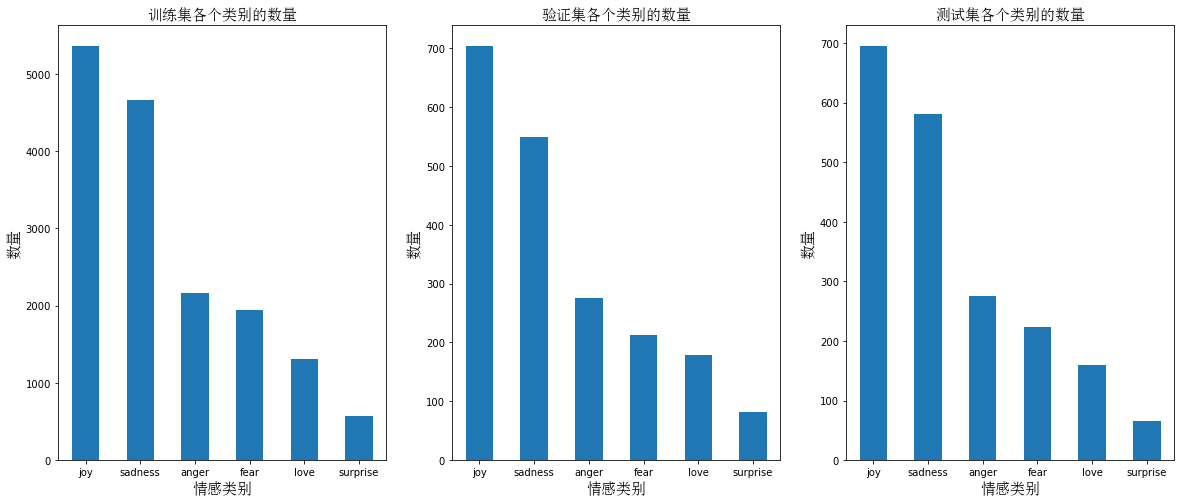

In [6]:
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)
# 可视化label的分布
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
train_df['label'].value_counts().plot(kind='bar')
# plt.bar(train_df['label'].value_counts().index,train_df['label'].value_counts())
plt.title(u"训练集各个类别的数量",fontproperties=font_set)
plt.xlabel(u"情感类别",fontproperties=font_set)
plt.xticks(rotation=0)
plt.ylabel(u"数量",fontproperties=font_set)

plt.subplot(1, 3, 2)
val_df['label'].value_counts().plot(kind='bar')
# plt.bar(train_df['label'].value_counts().index,train_df['label'].value_counts())
plt.title(u"验证集各个类别的数量",fontproperties=font_set)
plt.xlabel(u"情感类别",fontproperties=font_set)
plt.xticks(rotation=0)
plt.ylabel(u"数量",fontproperties=font_set)


plt.subplot(1, 3, 3)
test_df['label'].value_counts().plot(kind='bar')
# plt.bar(train_df['label'].value_counts().index,train_df['label'].value_counts())
plt.title(u"测试集各个类别的数量",fontproperties=font_set)
plt.xlabel(u"情感类别",fontproperties=font_set)
plt.xticks(rotation=0)
plt.ylabel(u"数量",fontproperties=font_set)
plt.show()

### 文本处理

In [7]:
def text_process(text):
    text = ' '+text
    # 小写
    text = text.lower()    
    # 缩写更正
    # 在该文本中没有”’“，只存在两种情况
    # 1、省略”‘“
    # 2、用空格代替”’“
    text = re.sub(r" im ", "i am ", text)
    text = re.sub(r" hes ", " he is ", text)
    text = re.sub(r" shes ", " she is ", text)
    text = re.sub(r" ive ", " i have ", text)
    text = re.sub(r" thats ", " that is ", text)        
    text = re.sub(r" whats ", " what is ", text)
    text = re.sub(r" wheres ", " where is ", text)
    text = re.sub(r" cannt ", " can not ", text)
    text = re.sub(r" couldnt ", " could not ", text)
    text = re.sub(r" donnt ", " do not ", text)
    text = re.sub(r" didnt ", " did not ", text)
    text = re.sub(r" doesnt ", " does not ", text)
    text = re.sub(r" havent ", " have not", text)
    
    text = re.sub(r" i m ", " i am ", text)
    text = re.sub(r" he s ", " he is ", text)
    text = re.sub(r" she s ", " she is ", text)
    text = re.sub(r" it s ", " it is ", text)
    text = re.sub(r" i ve ", " i have ", text)
    text = re.sub(r" i ll ", " i will ", text)
    text = re.sub(r" that s ", " that is ", text)        
    text = re.sub(r" what s ", " what is ", text)
    text = re.sub(r" where s ", " where is ", text) 
    text = re.sub(r" can t ", " can not ", text)
    text = re.sub(r" could t ", " could not ", text)
    text = re.sub(r" don t ", " do not ", text)
    text = re.sub(r" did t ", " did not ", text)
    text = re.sub(r" does t ", " does not ", text)
    text = re.sub(r" have t ", " have not", text)
    
    # 符号删除
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    # 去停词
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    # 分词
    tokens = word_tokenize(text)
    text = [word for word in tokens if word.isalpha()]
    return text

print(train_df['text'][0])
text_process(train_df['text'][0])

i didnt feel humiliated


['feel', 'humiliated']

In [8]:
train_df["word"] = train_df["text"].apply(text_process)
test_df["word"] = test_df["text"].apply(text_process)
val_df["word"] = val_df["text"].apply(text_process)

In [9]:
train_df.head(5)

,text,label,word
0,i didnt feel humiliated,sadness,"[feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,"[feeling, grouchy]"


### LabelEncoding

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df["label"])
train_df["encoded_label"] = label_encoder.transform(train_df["label"])
val_df["encoded_label"] = label_encoder.transform(val_df["label"])
test_df["encoded_label"] = label_encoder.transform(test_df["label"])

In [11]:
train_df.drop_duplicates(subset=['encoded_label'],keep='first')

,text,label,word,encoded_label
0,i didnt feel humiliated,sadness,"[feel, humiliated]",4
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, feel, greedy, wrong]",0
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st...",3
6,ive been taking or milligrams or times recomme...,surprise,"[taking, milligrams, times, recommended, amoun...",5
7,i feel as confused about life as a teenager or...,fear,"[feel, confused, life, teenager, jaded, year, ...",1
8,i have been with petronas for years i feel tha...,joy,"[petronas, years, feel, petronas, performed, w...",2


### 构造数据对

In [12]:
word_len = [len(i) for i in train_df["word"]]
max_w_len = max(word_len)
print("max_word_len:",max_w_len)

max_word_len: 35


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([train_df["word"]],axis=0))
vocab_size = len(tokenizer.word_index) + 1 
vocab_size

17248

In [14]:
def make_data1(word,label):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(pd.concat([train_df["word"]],axis=0))
    X_seq = tokenizer.texts_to_sequences(word)
    X_seq_pad = pad_sequences(X_seq, padding='post', maxlen=max_w_len)
    label = label.values
    
    return torch.LongTensor(X_seq_pad).to(device),torch.LongTensor(label).to(device)

inputs,label = make_data1(train_df['word'],train_df['encoded_label'])
dataset = Data.TensorDataset(inputs,label)
loader1 = Data.DataLoader(dataset, batch_size, False)
for i,(x, y) in enumerate(loader1):
    if i==0:
        print(x,y)

tensor([[   1,  561,    0,  ...,    0,    0,    0],
        [  29,    2,  376,  ...,    0,    0,    0],
        [2937, 1023,  180,  ...,    0,    0,    0],
        ...,
        [   1,   31,  251,  ...,    0,    0,    0],
        [   1,   31,  601,  ...,    0,    0,    0],
        [   2,  629,  369,  ...,    0,    0,    0]]) tensor([4, 4, 0, 3, 0, 4, 5, 1, 2, 3, 4, 2, 0, 4, 2, 2, 4, 4, 4, 1, 0, 1, 2, 2,
        0, 4, 4, 4, 0, 2, 2, 1, 5, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 4, 4, 2, 3,
        2, 0, 2, 4, 0, 1, 2, 4, 4, 5, 2, 2, 2, 3, 1, 1, 5, 0, 0, 4, 3, 2, 4, 4,
        2, 4, 4, 4, 2, 2, 2, 0, 4, 0, 0, 0, 2, 2, 2, 2, 4, 1, 3, 0, 4, 0, 3, 4,
        2, 2, 4, 0, 3, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 3, 4, 4, 2, 2, 4, 2, 2,
        1, 1, 1, 4, 3, 2, 2, 3])


In [15]:
def make_data2(word,label):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(pd.concat([train_df["word"]],axis=0))
    word = tokenizer.texts_to_sequences(word)
    
    seq_pairs = sorted(zip(word, label), key=lambda p: len(p[0]), reverse=True) #根据长度降序排序
    word, label = zip(*seq_pairs) #解包
    
    word = pad_sequences(word, padding='post', maxlen=max_w_len)
    
    return torch.LongTensor(word).to(device),torch.LongTensor(label).to(device)

In [16]:
inputs,label = make_data2(train_df['word'],train_df['encoded_label'])
dataset = Data.TensorDataset(inputs,label)
loader = Data.DataLoader(dataset, batch_size, False)
for i,(x, y) in enumerate(loader):
    if i==0:
        print(x,y)

tensor([[  654, 13065, 13066,  ..., 13074,  1881,  3585],
        [    1,     3,    76,  ...,    83,   534,     0],
        [    1,    24,   195,  ..., 12268,  4278,     0],
        ...,
        [   14,     1,   149,  ...,     0,     0,     0],
        [14891,   823,   190,  ...,     0,     0,     0],
        [    1,   635,    15,  ...,     0,     0,     0]]) tensor([2, 2, 1, 4, 4, 0, 2, 0, 1, 4, 2, 4, 1, 4, 5, 2, 3, 0, 2, 3, 2, 4, 4, 3,
        5, 2, 3, 4, 4, 4, 0, 2, 2, 4, 1, 0, 0, 2, 4, 4, 3, 4, 2, 2, 0, 1, 2, 2,
        1, 4, 4, 2, 1, 4, 2, 4, 4, 3, 4, 4, 4, 2, 0, 1, 0, 2, 0, 3, 2, 0, 1, 2,
        2, 4, 1, 2, 4, 2, 2, 4, 4, 1, 5, 2, 0, 0, 2, 4, 0, 4, 2, 4, 2, 4, 0, 4,
        3, 4, 2, 0, 2, 4, 0, 2, 2, 4, 4, 4, 2, 4, 4, 1, 2, 4, 2, 4, 1, 0, 1, 2,
        3, 2, 0, 5, 3, 0, 0, 2])


### TextCNN

In [18]:
class TextCNN(nn.Module):
    # 多通道textcnn
    def __init__(self ):
        super(TextCNN, self).__init__()
        global filter_size,filter_num,num_classes,vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 并列卷积
        self.convs = nn.ModuleList([nn.Conv2d(1,filter_num_textcnn,(fsz,embedding_dim)) for fsz in filter_size])
        self.linear = nn.Linear(len(filter_size)*filter_num_textcnn, num_classes)

    def forward(self, x):
        # x:[B,max_w_len]
        x = self.embedding(x)
        x = F.dropout(x,p=0.2)
        # x:[B,max_w_len,embedding_dim]
        x = x.unsqueeze(1)
        # x:[B,1,max_w_len,embedding_dim]
        x = [F.relu(conv(x)) for conv in self.convs]
        # x:[[B, filter_num_textcnn, max_w_len-3+1, h=1],
        #    [B, filter_num_textcnn, max_w_len-4+1, h=1],
        #    [B, filter_num_textcnn, max_w_len-5+1, h=1]]
        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), 1)) for x_item in x]
        # x:[[B, filter_num_textcnn,1,1],
        #    [B, filter_num_textcnn,1,1],
        #    [B, filter_num_textcnn,1,1]]
        x = [x_item.squeeze(3).squeeze(2) for x_item in x]
        # x:[[B, filter_num_textcnn],
        #    [B, filter_num_textcnn],
        #    [B, filter_num_textcnn]]
        x = torch.cat(x, 1)
        # x: [B,filter_num_textcnn*3]
        x = F.dropout(x,p=0.2)
        out = self.linear(x)
        
        return out
    

In [90]:
model2 = TextCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

x_train, y_train = make_data1(train_df['word'],train_df['encoded_label'])
train_dataset = Data.TensorDataset(x_train, y_train)
loader2 = Data.DataLoader(train_dataset, batch_size, False)

x_val, y_val = make_data1(val_df['word'],val_df['encoded_label'])

In [91]:
train_acc_lst2,val_acc_lst2=[],[]
train_loss_lst2,val_loss_lst2=[],[]

for epoch in range(30):
    model2.train()
    for i,(x, y) in enumerate(loader2):
        pred = model2(x)
        loss = criterion(pred,y)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
    
    model2.eval()
    train_pred = model2(x_train)
    train_loss = criterion(train_pred,y_train)
    train_loss_lst2.append(train_loss.item())
    _,train_pre_label = torch.max(train_pred, 1)
    train_acc = accuracy_score(train_pre_label, y_train)
    train_acc_lst2.append(train_acc)
    
    val_pred = model2(x_val)
    val_loss = criterion(val_pred,y_val)
    val_loss_lst2.append(val_loss.item())
    _,val_pre_label = torch.max(val_pred, 1)
    val_acc = accuracy_score(val_pre_label, y_val)
    val_acc_lst2.append(val_acc)
    
    print('Epoch: %02d/30:' % (epoch+1),'train_loss = {:.6f}, val_loss = {:.6f}, train_acc = {:.6f}, val_acc = {:.6f}'.format(train_loss,val_loss,train_acc,val_acc))


Epoch: 01/30: train_loss = 1.454750, val_loss = 1.489771, train_acc = 0.416625, val_acc = 0.412500
Epoch: 02/30: train_loss = 1.238033, val_loss = 1.299400, train_acc = 0.533813, val_acc = 0.496500
Epoch: 03/30: train_loss = 0.956699, val_loss = 1.071118, train_acc = 0.650000, val_acc = 0.592000
Epoch: 04/30: train_loss = 0.713067, val_loss = 0.882261, train_acc = 0.745500, val_acc = 0.673500
Epoch: 05/30: train_loss = 0.530134, val_loss = 0.704761, train_acc = 0.814625, val_acc = 0.736500
Epoch: 06/30: train_loss = 0.415648, val_loss = 0.600386, train_acc = 0.858875, val_acc = 0.778000
Epoch: 07/30: train_loss = 0.335563, val_loss = 0.546763, train_acc = 0.878625, val_acc = 0.800000
Epoch: 08/30: train_loss = 0.279458, val_loss = 0.479441, train_acc = 0.901813, val_acc = 0.828000
Epoch: 09/30: train_loss = 0.241519, val_loss = 0.451881, train_acc = 0.917063, val_acc = 0.848500
Epoch: 10/30: train_loss = 0.210907, val_loss = 0.417319, train_acc = 0.926562, val_acc = 0.862500
Epoch: 11/

In [92]:
torch.save(model2.state_dict(),'TextCNN_2.pkl')

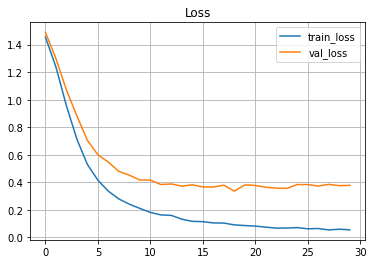

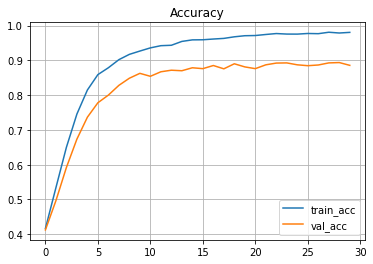

In [93]:
# 绘制loss、acc曲线图
plt.plot(np.arange(30),train_loss_lst2,label="train_loss")
plt.plot(np.arange(30),val_loss_lst2,label="val_loss")
plt.legend()
plt.grid()
plt.title('Loss')
plt.show()

plt.plot(np.arange(30),train_acc_lst2,label="train_acc")
plt.plot(np.arange(30),val_acc_lst2,label="val_acc")
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.show()

### BiLSTM-Atten 处理变长

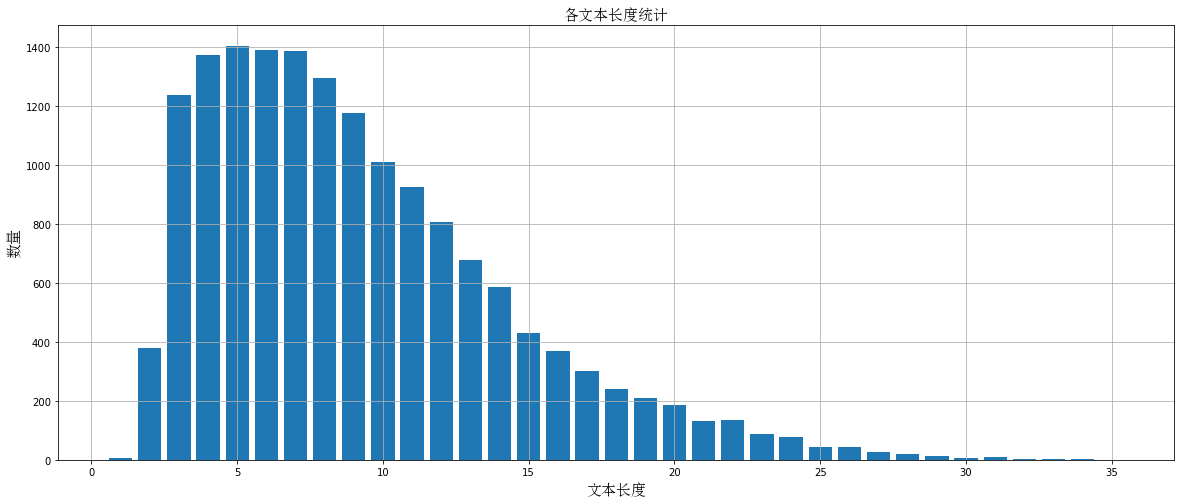

In [27]:
word_len_ = pd.DataFrame({"word_len": word_len})
plt.figure(figsize=(20,8))
plt.bar(np.arange(1,36),word_len_.value_counts().sort_index().values)
# word_len_.value_counts().sort_index().plot(kind='bar')
plt.title(u"各文本长度统计",fontproperties=font_set)
plt.grid()
plt.xlabel(u"文本长度",fontproperties=font_set)
plt.xticks(rotation=0)
plt.ylabel(u"数量",fontproperties=font_set)
plt.show()

In [20]:
class BiLSTM_atten_(nn.Module):
    def __init__(self):
        super(BiLSTM_atten_, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True, batch_first=True)
        self.out = nn.Linear(n_hidden*2, num_classes)
        self.w_linear = nn.Linear(n_hidden*2, n_hidden*2)

    def attention_net(self,lstm_output, final_state):
        # lstm_output : [batch_size, max_w_len, n_hidden * num_directions(=2)]
        # final_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        batch_size = len(lstm_output)
        # final_state[0]---正向；final_state[1]---逆向。
        hidden_ = torch.cat((final_state[0],final_state[1]),dim=1)
        # hidden_: [B,H*2]
        hidden = hidden_.unsqueeze(2)
#         W_Hs = self.w_linear(lstm_output)

        # lstm_out:[B, max_w_len, H*2]
        # hidden:[B,H*2,1]
        # atten_weight:[B,max_w_len,1]
        atten_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        soft_atten_weights = F.softmax(atten_weights,1).unsqueeze(2)

        # lstm_out:[B, max_w_len, H*2] ->[B, H*2,max_w_len]
        # soft_attn_weights:[B,max_w_len,1]
        # context:[B,H*2,1]
        lstm_output = lstm_output.transpose(1,2)
        context = torch.bmm(lstm_output,soft_atten_weights).squeeze(2)
        
        return context, soft_atten_weights

    def forward(self,X):
        word_len = [int(i.argmin()) if i[-1]==0 else max_w_len for i in X]
        
        x_input = self.embedding(X)
        x_input = F.dropout(x_input,p=0.2)
        
        embed_input_x_packed = pack_padded_sequence(x_input,word_len,batch_first=True)
        output, (final_hidden_state, final_cell_state) = self.lstm(embed_input_x_packed)
        output,_ = pad_packed_sequence(output, batch_first=True)
        
        attn_output, attention = self.attention_net(output,final_hidden_state)
        attn_output = F.dropout(attn_output,p=0.2)
        
        return self.out(attn_output),attention 


In [99]:
model3 = BiLSTM_atten_().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)

x_train, y_train = make_data2(train_df['word'],train_df['encoded_label'])
train_dataset = Data.TensorDataset(x_train, y_train)
loader3 = Data.DataLoader(train_dataset, batch_size, False)

x_val, y_val = make_data2(val_df['word'],val_df['encoded_label'])

In [100]:
train_acc_lst3,val_acc_lst3=[],[]
train_loss_lst3,val_loss_lst3=[],[]

for epoch in range(30):
    model3.train()
    for i,(x, y) in enumerate(loader3):
        pred, atten = model3(x)
        loss = criterion(pred,y)
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
    
    model3.eval()
    train_pred, train_atten = model3(x_train)
    train_loss = criterion(train_pred,y_train)
    train_loss_lst3.append(train_loss.item())
    _,train_pre_label = torch.max(train_pred, 1)
    train_acc = accuracy_score(train_pre_label, y_train)
    train_acc_lst3.append(train_acc)
    
    val_pred, val_atten = model3(x_val)
    val_loss = criterion(val_pred,y_val)
    val_loss_lst3.append(val_loss.item())
    _,val_pre_label = torch.max(val_pred, 1)
    val_acc = accuracy_score(val_pre_label, y_val)
    val_acc_lst3.append(val_acc)
    
    print('Epoch: %02d/30:' % (epoch+1),'train_loss = {:.6f}, val_loss = {:.6f}, train_acc = {:.6f}, val_acc = {:.6f}'.format(train_loss,val_loss,train_acc,val_acc))


Epoch: 01/30: train_loss = 2.127526, val_loss = 2.071435, train_acc = 0.413562, val_acc = 0.415500
Epoch: 02/30: train_loss = 1.275527, val_loss = 1.322526, train_acc = 0.533625, val_acc = 0.523500
Epoch: 03/30: train_loss = 0.913376, val_loss = 0.993541, train_acc = 0.676625, val_acc = 0.661500
Epoch: 04/30: train_loss = 0.698400, val_loss = 0.819472, train_acc = 0.762813, val_acc = 0.720500
Epoch: 05/30: train_loss = 0.480197, val_loss = 0.629433, train_acc = 0.835750, val_acc = 0.799500
Epoch: 06/30: train_loss = 0.354867, val_loss = 0.495208, train_acc = 0.875313, val_acc = 0.830500
Epoch: 07/30: train_loss = 0.299656, val_loss = 0.455217, train_acc = 0.894687, val_acc = 0.846500
Epoch: 08/30: train_loss = 0.232160, val_loss = 0.416694, train_acc = 0.915125, val_acc = 0.854000
Epoch: 09/30: train_loss = 0.218125, val_loss = 0.401806, train_acc = 0.921813, val_acc = 0.864500
Epoch: 10/30: train_loss = 0.183600, val_loss = 0.382687, train_acc = 0.931375, val_acc = 0.862000
Epoch: 11/

In [101]:
# 保存模型参数
torch.save(model3.state_dict(),'BiLSTM_padded_Atten_2.pkl')

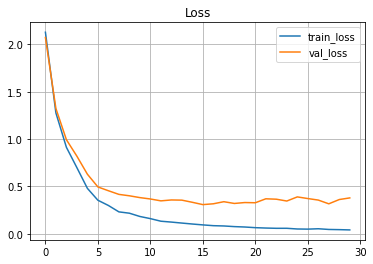

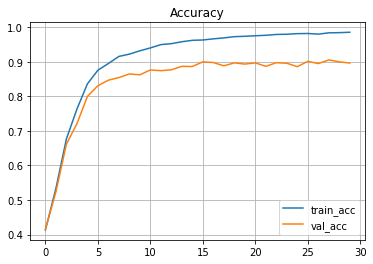

In [102]:
# 绘制loss、acc曲线图
plt.plot(np.arange(30),train_loss_lst3,label="train_loss")
plt.plot(np.arange(30),val_loss_lst3,label="val_loss")
plt.legend()
plt.grid()
plt.title('Loss')
plt.show()

plt.plot(np.arange(30),train_acc_lst3,label="train_acc")
plt.plot(np.arange(30),val_acc_lst3,label="val_acc")
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.show()

### CNN-BiLSTM-Atten

In [21]:
class CNN_BiLSTM(nn.Module):
    def __init__(self):
        super(CNN_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,(3,embedding_dim)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,1))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,32,(3,1)), 
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(3,1))
        )

        self.lstm = nn.LSTM(32,n_hidden,bidirectional=True, batch_first=True)
        self.out = nn.Linear(n_hidden*2,6)
        
        
    def attention_net(self,lstm_output, final_state):
        batch_size = len(lstm_output)
        hidden_ = torch.cat((final_state[0],final_state[1]),dim=1)
        hidden = hidden_.unsqueeze(2)
        atten_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        soft_atten_weights = F.softmax(atten_weights,1).unsqueeze(2)
        lstm_output = lstm_output.transpose(1,2)
        context = torch.bmm(lstm_output,soft_atten_weights).squeeze(2)
        
        return context, soft_atten_weights

    def forward(self,X):
        batch_size = len(X)
        x_input = self.embedding(X)
#         x_input = F.dropout(x_input,p=0.2)
        # x_input:[B,max_w_len,embedding_dim]
        x_input = x_input.unsqueeze(1)
        # x_input:[B,1,max_w_len,embedding_dim]
        x_input = self.conv1(x_input)
        # x_input:[B,32,11,1]
        x_input = F.dropout(x_input,p=0.4)
#         x_input = self.conv2(x_input)
        x_input = x_input.view(batch_size,11,32)
#         x_input = F.dropout(x_input,p=0.2)
        output, (final_hidden_state, final_cell_state) = self.lstm(x_input)
        attn_output, attention = self.attention_net(output,final_hidden_state)
#         attn_output = F.dropout(attn_output,p=0.2)
        
        return self.out(attn_output),attention 

In [25]:
model4 = CNN_BiLSTM().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.003)

x_train, y_train = make_data1(train_df['word'],train_df['encoded_label'])
train_dataset = Data.TensorDataset(x_train, y_train)
loader4 = Data.DataLoader(train_dataset, batch_size, False)

x_val, y_val = make_data1(val_df['word'],val_df['encoded_label'])

In [26]:
train_acc_lst4,val_acc_lst4=[],[]
train_loss_lst4,val_loss_lst4=[],[]

for epoch in range(30):
    model4.train()
    for i,(x, y) in enumerate(loader4):
        pred, atten = model4(x)
        loss = criterion(pred,y)
        optimizer4.zero_grad()
        loss.backward()
        optimizer4.step()
    
    model4.eval()
    train_pred, train_atten = model4(x_train)
    train_loss = criterion(train_pred,y_train)
    train_loss_lst4.append(train_loss.item())
    _,train_pre_label = torch.max(train_pred, 1)
    train_acc = accuracy_score(train_pre_label, y_train)
    train_acc_lst4.append(train_acc)
    
    val_pred, val_atten = model4(x_val)
    val_loss = criterion(val_pred,y_val)
    val_loss_lst4.append(val_loss.item())
    _,val_pre_label = torch.max(val_pred, 1)
    val_acc = accuracy_score(val_pre_label, y_val)
    val_acc_lst4.append(val_acc)
    
    print('Epoch: %02d/30:' % (epoch+1),'train_loss = {:.6f}, val_loss = {:.6f}, train_acc = {:.6f}, val_acc = {:.6f}'.format(train_loss,val_loss,train_acc,val_acc))


Epoch: 01/30: train_loss = 1.434063, val_loss = 1.486163, train_acc = 0.451188, val_acc = 0.422000
Epoch: 02/30: train_loss = 1.051479, val_loss = 1.113948, train_acc = 0.591000, val_acc = 0.566500
Epoch: 03/30: train_loss = 0.743562, val_loss = 0.900676, train_acc = 0.695187, val_acc = 0.648000
Epoch: 04/30: train_loss = 0.541991, val_loss = 0.710946, train_acc = 0.771500, val_acc = 0.724000
Epoch: 05/30: train_loss = 0.400610, val_loss = 0.614798, train_acc = 0.847187, val_acc = 0.777000
Epoch: 06/30: train_loss = 0.299939, val_loss = 0.565433, train_acc = 0.889750, val_acc = 0.810500
Epoch: 07/30: train_loss = 0.240265, val_loss = 0.532256, train_acc = 0.913563, val_acc = 0.824500
Epoch: 08/30: train_loss = 0.212909, val_loss = 0.524242, train_acc = 0.924125, val_acc = 0.838500
Epoch: 09/30: train_loss = 0.195066, val_loss = 0.519141, train_acc = 0.931875, val_acc = 0.848000
Epoch: 10/30: train_loss = 0.158966, val_loss = 0.516830, train_acc = 0.946187, val_acc = 0.845000
Epoch: 11/

In [75]:
torch.save(model4.state_dict(),'CNN-BiLSTM_Atten.pkl')

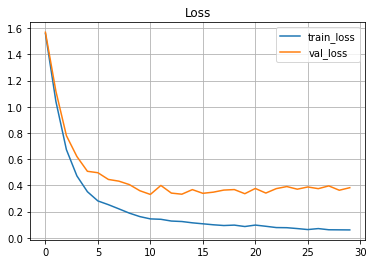

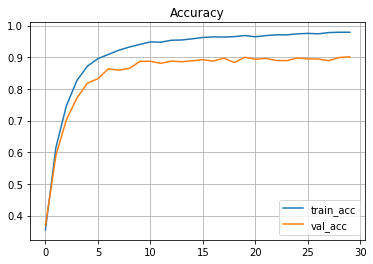

In [76]:
# 绘制loss、acc曲线图
plt.plot(np.arange(30),train_loss_lst4,label="train_loss")
plt.plot(np.arange(30),val_loss_lst4,label="val_loss")
plt.legend()
plt.grid()
plt.title('Loss')
plt.show()

plt.plot(np.arange(30),train_acc_lst4,label="train_acc")
plt.plot(np.arange(30),val_acc_lst4,label="val_acc")
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.show()

### BiLSTM_CNN

In [22]:
class BiLSTM_CNN(nn.Module):
    def __init__(self):
        super(BiLSTM_CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,n_hidden,bidirectional=True, batch_first=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,(3,n_hidden*2)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,1))
        )
        self.out = nn.Linear(11*32,6)
        
    def forward(self,X):
        batch_size = len(X)
        x_input = self.embedding(X)
        output, (final_hidden_state, final_cell_state) = self.lstm(x_input)
        # output:[B,max_w_len,n_hidden*2]
        output = output.unsqueeze(1)
        # output:[B,1,max_w_len,n_hidden*2]
        output = self.conv1(output)
        # output:[B,1,11,1]
        output = F.dropout(output,p=0.5)
        output = output.view(batch_size,11*32)
        output = F.dropout(output,p=0.2)
        
        return self.out(output)

In [23]:
model5 = BiLSTM_CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.002)

x_train, y_train = make_data2(train_df['word'],train_df['encoded_label'])
train_dataset = Data.TensorDataset(x_train, y_train)
loader5 = Data.DataLoader(train_dataset, batch_size, False)

x_val, y_val = make_data2(val_df['word'],val_df['encoded_label'])

In [24]:
train_acc_lst5,val_acc_lst5=[],[]
train_loss_lst5,val_loss_lst5=[],[]

for epoch in range(30):
    model5.train()
    for i,(x, y) in enumerate(loader5):
        pred = model5(x)
        loss = criterion(pred,y)
        optimizer5.zero_grad()
        loss.backward()
        optimizer5.step()
    
    model5.eval()
    train_pred = model5(x_train)
    train_loss = criterion(train_pred,y_train)
    train_loss_lst5.append(train_loss.item())
    _,train_pre_label = torch.max(train_pred, 1)
    train_acc = accuracy_score(train_pre_label, y_train)
    train_acc_lst5.append(train_acc)
    
    val_pred = model5(x_val)
    val_loss = criterion(val_pred,y_val)
    val_loss_lst5.append(val_loss.item())
    _,val_pre_label = torch.max(val_pred, 1)
    val_acc = accuracy_score(val_pre_label, y_val)
    val_acc_lst5.append(val_acc)
    
    x_test, y_test = make_data1(test_df['word'],test_df['encoded_label'])
    
    print('Epoch: %02d/30:' % (epoch+1),'train_loss = {:.6f}, val_loss = {:.6f}, train_acc = {:.6f}, val_acc = {:.6f}'.format(train_loss,val_loss,train_acc,val_acc))


Epoch: 01/30: train_loss = 2.699283, val_loss = 2.854805, train_acc = 0.491812, val_acc = 0.480000
Epoch: 02/30: train_loss = 0.863215, val_loss = 1.014087, train_acc = 0.710938, val_acc = 0.669500
Epoch: 03/30: train_loss = 0.420816, val_loss = 0.621218, train_acc = 0.855062, val_acc = 0.797000
Epoch: 04/30: train_loss = 0.221400, val_loss = 0.480110, train_acc = 0.922063, val_acc = 0.856000
Epoch: 05/30: train_loss = 0.156154, val_loss = 0.523977, train_acc = 0.945438, val_acc = 0.868000
Epoch: 06/30: train_loss = 0.099607, val_loss = 0.441170, train_acc = 0.964562, val_acc = 0.881500
Epoch: 07/30: train_loss = 0.071732, val_loss = 0.514641, train_acc = 0.975812, val_acc = 0.878000
Epoch: 08/30: train_loss = 0.061687, val_loss = 0.557740, train_acc = 0.979437, val_acc = 0.881500
Epoch: 09/30: train_loss = 0.053903, val_loss = 0.566543, train_acc = 0.981187, val_acc = 0.880500
Epoch: 10/30: train_loss = 0.036921, val_loss = 0.587723, train_acc = 0.986750, val_acc = 0.882500
Epoch: 11/

In [ ]:
torch.save(model5.state_dict(),'BiLSTM-CNN_1.pkl')

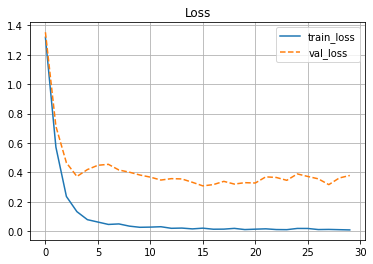

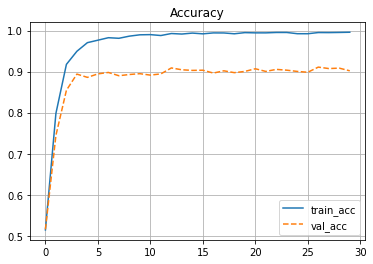

In [303]:
# 绘制loss、acc曲线图
plt.plot(np.arange(30),train_loss_lst5,label="train_loss")
plt.plot(np.arange(30),val_loss_lst5,label="val_loss",linestyle='--')
plt.legend()
plt.grid()
plt.title('Loss')
plt.show()

plt.plot(np.arange(30),train_acc_lst5,label="train_acc")
plt.plot(np.arange(30),val_acc_lst5,label="val_acc",linestyle='--')
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.show()

### 模型评价指标

In [110]:
# lstm1 = BiLSTM_Attention().to(device)
# lstm1.load_state_dict(torch.load("./BiLSTM_Atten_2.pkl"))
textcnn = TextCNN().to(device)
textcnn.load_state_dict(torch.load("./TextCNN_2.pkl"))
lstm2 = BiLSTM_atten_().to(device)
lstm2.load_state_dict(torch.load("./BiLSTM_padded_Atten_2.pkl"))
cnn_bilstm = CNN_BiLSTM().to(device)
cnn_bilstm.load_state_dict(torch.load("./CNN-BiLSTM_Atten.pkl"))
bilstm_cnn = BiLSTM_CNN().to(device)
bilstm_cnn.load_state_dict(torch.load("./BiLSTM-CNN.pkl"))

criterion = nn.CrossEntropyLoss().to(device)
x_test, y_test = make_data1(test_df['word'],test_df['encoded_label'])
x_test_, y_test_ = make_data2(test_df['word'],test_df['encoded_label'])

In [111]:
# pred_lst1 =[]
# lstm1.eval()
# pred,_ = lstm1(x_test)
# _,pre_label = torch.max(pred, 1)
# pred_lst1.append(pre_label.data)

pred_lst2 =[]
textcnn.eval()
pred = textcnn(x_test)
_,pre_label = torch.max(pred, 1)
pred_lst2.append(pre_label.data)

pred_lst3 =[]
lstm2.eval()
pred,_ = lstm2(x_test_)
_,pre_label = torch.max(pred, 1)
pred_lst3.append(pre_label.data)

pred_lst4 =[]
cnn_bilstm.eval()
pred,_ = cnn_bilstm(x_test)
_,pre_label = torch.max(pred, 1)
pred_lst4.append(pre_label.data)

pred_lst5 =[]
bilstm_cnn .eval()
pred = bilstm_cnn(x_test)
_,pre_label = torch.max(pred, 1)
pred_lst5.append(pre_label.data)

In [163]:
print(classification_report(y_test.numpy(),np.array(pred_lst2[0]),digits=4))

              precision    recall  f1-score   support

           0     0.8736    0.8545    0.8640       275
           1     0.8333    0.8705    0.8515       224
           2     0.9126    0.9165    0.9146       695
           3     0.8027    0.7421    0.7712       159
           4     0.8988    0.9174    0.9080       581
           5     0.7288    0.6515    0.6880        66

    accuracy                         0.8805      2000
   macro avg     0.8417    0.8254    0.8329      2000
weighted avg     0.8796    0.8805    0.8798      2000



In [164]:
print(classification_report(y_test_.numpy(),np.array(pred_lst3[0]),digits=4))

              precision    recall  f1-score   support

           0     0.8772    0.9091    0.8929       275
           1     0.8547    0.8929    0.8734       224
           2     0.9260    0.9180    0.9220       695
           3     0.7651    0.7987    0.7815       159
           4     0.9492    0.9329    0.9410       581
           5     0.8364    0.6970    0.7603        66

    accuracy                         0.9015      2000
   macro avg     0.8681    0.8581    0.8618      2000
weighted avg     0.9023    0.9015    0.9015      2000



In [165]:
print(classification_report(y_test.numpy(),np.array(pred_lst4[0]),digits=4))

              precision    recall  f1-score   support

           0     0.8500    0.8655    0.8577       275
           1     0.8779    0.8348    0.8558       224
           2     0.9216    0.8964    0.9088       695
           3     0.6720    0.7987    0.7299       159
           4     0.9410    0.9329    0.9369       581
           5     0.6970    0.6970    0.6970        66

    accuracy                         0.8815      2000
   macro avg     0.8266    0.8375    0.8310      2000
weighted avg     0.8852    0.8815    0.8828      2000



In [272]:
print(classification_report(y_test.numpy(),np.array(pred_lst5[0]),digits=4))

              precision    recall  f1-score   support

           0     0.8799    0.9055    0.8925       275
           1     0.8929    0.8929    0.8929       224
           2     0.9185    0.9410    0.9296       695
           3     0.8255    0.7736    0.7987       159
           4     0.9629    0.9380    0.9503       581
           5     0.8182    0.8182    0.8182        66

    accuracy                         0.9125      2000
   macro avg     0.8830    0.8782    0.8804      2000
weighted avg     0.9125    0.9125    0.9123      2000

